In [97]:
import numpy as np
import gym

from collections import defaultdict

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

In [98]:
env = gym.make("Blackjack-v0")

In [99]:
env.observation_space

Tuple(Discrete(32), Discrete(11), Discrete(2))

In [100]:
env.action_space

Discrete(2)

In [101]:
observation = env.reset()
observation

(13, 3, False)

## Prediction

In [102]:
def generate_episode(policy, env):
    states, actions, rewards = [], [], []
    observation = env.reset()
    
    while True:
        states.append(observation)
        
        action = policy(observation)
        observation, reward, done, _ = env.step(action)
        
        actions.append(action)
        rewards.append(reward)
        
        if done:
            break
            
    return states, actions, rewards

In [103]:
def first_visit_mc_prediction(policy, env, n_episodes):
    value_table = defaultdict(float)
    N = defaultdict(int)
    
    for _ in range(n_episodes):
        states, actions, rewards = generate_episode(policy, env)
        returns = 0
        for t in range(len(states)-1, -1, -1):
            s = states[t]
            r = rewards[t]
            returns += r
            
            if s not in states[:t]: # first-visit state s
                N[s] += 1
                value_table[s] += (returns - value_table[s]) / N[s] # Incremental
    
    return value_table

In [104]:
def sample_policy(observation):
    score, dealer_score, usable_ace = observation
    
    if score >= 20:
        return 0
    else:
        return 1

In [105]:
value = first_visit_mc_prediction(sample_policy, env, 500000)

#### 图示

In [106]:
def plot_blackjack(V, ax1, ax2):
    player_sum = np.arange(12, 21 + 1)
    dealer_show = np.arange(1, 10 + 1)
    usable_ace = np.array([False, True])

    state_values = np.zeros((len(player_sum),
                                len(dealer_show),
                                len(usable_ace)))

    for i, player in enumerate(player_sum):
        for j, dealer in enumerate(dealer_show):
            for k, ace in enumerate(usable_ace):
                state_values[i, j, k] = V[player, dealer, ace]

    X, Y = np.meshgrid(dealer_show, player_sum) # Y, X

    ax1.plot_wireframe(X, Y, state_values[:, :, 0])
    ax2.plot_wireframe(X, Y, state_values[:, :, 1])
    for ax in ax1, ax2:
        ax.set_zlim(-1, 1)
        ax.set_ylabel('player sum')
        ax.set_xlabel('dealer showing')
        ax.set_zlabel('state-value')

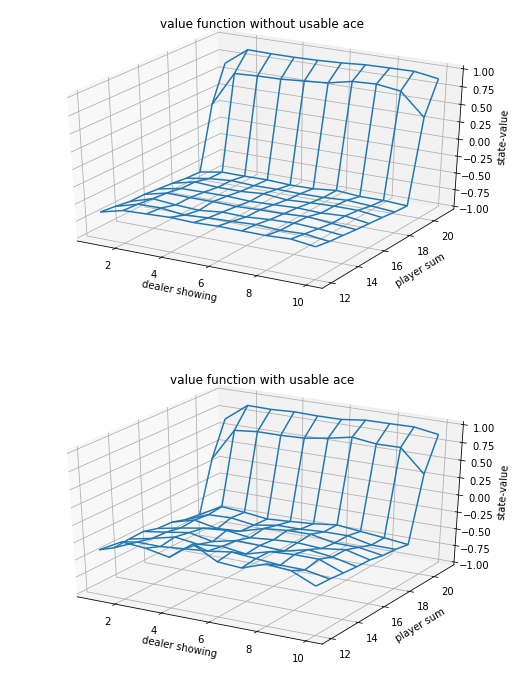

In [107]:
fig, axes = plt.subplots(nrows=2, figsize=(9, 12), subplot_kw={'projection': '3d'})
axes[0].set_title('value function without usable ace')
axes[1].set_title('value function with usable ace')
plot_blackjack(value, axes[0], axes[1])

## Control